In [1]:
import pandas as pd
import json
import dateparser
%pylab inline
#print dateparser.parse(" 1200").date()

#load about_pages
about_pages=pd.read_csv('de/all_data_bias_labour_gender.csv',sep='\t', encoding='utf-8',index_col=0)#885
df=about_pages
#Remove data where there is no male person neither female  simultaneously
df_0=df[(df.male_person_amount==0)& (df.female_person_amount==0)]#628
df=df[(df.male_person_amount>0)| (df.female_person_amount>0)]#257
print "There are ",len(df),"profesions with at least one person"

Populating the interactive namespace from numpy and matplotlib
There are  257 profesions with at least one person


In [12]:
from wikitools import wiki, api
from datetime import datetime, timedelta, date

def get_text(titles):
    site = wiki.Wiki("https://de.wikipedia.org/w/api.php") 
    params={'action':'query','titles':titles,'formatversion':'2',
                    'prop':'extracts','exintro':'','explaintext':'',
                    'redirects':'','continue':''}
    request = api.APIRequest(site, params) 
    result=request.query()
    if result["query"]["pages"][0].get("title"):
        n=result["query"]["pages"][0]["extract"]
        if "(*" in n:
            try:
                #print dateparser.parse(n.split("(* ")[1].split(" in ")[0]).date()
                return dateparser.parse(n.split("(* ")[1].split(" in ")[0]).date()
            except:
                #print n
                pass
        else:
            #print n
            pass

def wikitool_retrieve(lang,titles): 
    w=""
    wikiid=0
    site = wiki.Wiki("https://"+lang+".wikipedia.org/w/api.php") 
    params={'action':'query','titles':titles,'prop':'langlinks', 
                 'lllang':'en','lllimit':'500','format':'json','redirects':'','continue':''} 
    request = api.APIRequest(site, params)   
    result=request.query() 
    if result["query"]["pages"].values()[0].get("title"): 
        n=result["query"]["pages"].values()[0] 
        if n.get("langlinks"): 
            w=n["langlinks"][0]["*"]
            site = wiki.Wiki("https://en.wikipedia.org/w/api.php") 
            params={'action':'query','titles':w,'format':'json','redirects':'','continue':''} 
            request = api.APIRequest(site, params) 
            result=request.query() 
            if result["query"]["pages"].values()[0].get("title"): 
                wikiid=result["query"]["pages"].values()[0]["pageid"]  
        else:
            return "99" , wikiid
            

            
    return w , wikiid


from SPARQLWrapper import SPARQLWrapper, JSON

def get_country_description(query):
    sparql = SPARQLWrapper("http://dbpedia.org/sparql")
    sparql.setReturnFormat(JSON)

    sparql.setQuery(query)  # the previous query as a literal string
    res=sparql.query().convert()
    return res["results"][u'bindings']



def wiki_dbpedia_age(titles):
    date_names=[]
    for title in titles:
        name,a=wikitool_retrieve("de",title) 
        if name=="99":
            print title, a
            date_names.append(get_text(title))
        elif a>0:
            query="""PREFIX dbo:<http://dbpedia.org/ontology/> 
            PREFIX dbp: <http://dbpedia.org/property/>
            SELECT ?age ?age2 WHERE { ?person dbo:wikiPageID """+str(a)+""" .
            {?person dbp:birthDate ?age .}
            UNION
             { ?person dbo:birthDate ?age2 . } }"""
            age=get_country_description(query)
            if len(age)>0:
                
                if len(age)>1:
                    if (age[1].has_key("age")): 
                        #print age[0]["age"]["type"],age[0]["age"]["value"]
                        date_names.append(age[0]["age"]["value"])
                    elif age[1]["age2"]["datatype"]==u'http://www.w3.org/2001/XMLSchema#date':
                        #print datetime.strptime(age[1]["age2"]["value"], '%Y-%m-%d').date()
                        if age[1]["age2"]["value"][0]!="-":
                            date_names.append(datetime.strptime(age[1]["age2"]["value"], '%Y-%m-%d').date())
                        else:
                            date_names.append(int(age[1]["age2"]["value"][:4]))
                    elif age[1]["age2"]["datatype"]==u'http://www.w3.org/2001/XMLSchema#gYear':
                        #print int(age[1]["age2"]["value"])
                        date_names.append(int(age[1]["age2"]["value"]))
                    else:
                        #print age[1]["age2"]["type"],age[1]["age2"]["value"] 
                        date_names.append(age[1]["age2"]["value"])
                elif age[0].has_key("age"):
                    if age[0]["age"].has_key("datatype"):
                        if age[0]["age"]["datatype"]==u'http://www.w3.org/2001/XMLSchema#date':
                            #print datetime.strptime(age[0]["age"]["value"], '%Y-%m-%d').date()
                            date_names.append(datetime.strptime(age[0]["age"]["value"], '%Y-%m-%d').date())
                    else:
                        #print age[0]["age"]["type"],age[0]["age"]["value"]
                        date_names.append(age[0]["age"]["value"])
                else:
                    
                    if age[0]["age2"]["datatype"]==u'http://www.w3.org/2001/XMLSchema#date':
                        #print datetime.strptime(age[0]["age2"]["value"], '%Y-%m-%d').date()
                        date_names.append(datetime.strptime(age[0]["age2"]["value"], '%Y-%m-%d').date())
                    else:
                        #print age[0]["age2"]["type"],age[0]["age2"]["value"]
                        date_names.append(age[0]["age2"]["value"])
            else:
                #print title, a
                date_names.append(get_text(title))
                #print "============>>>>>>>"
        else:
            #print "No page found"
            pass
    return date_names
#titles=["Archimedes","Sokrates","Fritz_Croner","Fritz_Schulz_(Schauspieler)",u'Heinrich_B\xf6ll']
#titles=["Fritz_Croner"]
#titles=[u'Wilhelm_Busch', u'Salomo', u'Imhotep', u'Sokrates', u'Platon', u'Zarathustra', u'Konfuzius', u'Laotse',
# u'Thomas_von_Aquin', u'Augustinus_von_Hippo', u'Ambrosius_von_Mailand', u'Basilius_von_Caesarea',
# u'Athanasius_der_Gro\xdfe', u'Albertus_Magnus', u'Benedikt_XVI.', u'Jean_Baptiste_de_La_Salle']
#wiki_dbpedia_age(titles)

In [10]:
from collections import defaultdict
dict_prof_names=defaultdict(dict)

for p,names in df.male_person.iteritems():
    list_names=names.replace("[","").replace("]","").split(", ")
    if list_names[0]!=u'':
        print list_names
        d=wiki_dbpedia_age(list_names)
        #print d
        dict_prof_names[p]["men"]=d
    else:
        pass

[u'Karl_Martell', u'Leo_X.', u'Franz_I._(Frankreich)', u'Leo_XIII.']
[u'Fritz_Croner', u'Michel_Crozier', u'Arnd_Zschiesche', u'Charles_Wright_Mills', u'J\xfcrgen_Kocka', u'Siegfried_Kracauer', u'Herman_Melville']
Fritz_Croner 0
1896-02-27
Arnd_Zschiesche 0
1972-05-27
[u'L\xe9o_Apotheker', u'Friedrich_II._(HRR)', u'Friedrich_Wilhelm_Adam_Sert\xfcrner', u'August_Oetker', u'Ernst_Christian_Friedrich_Schering', u'Emanuel_Merck', u'Carl_Leverkus', u'John_Pemberton', u'Felix_Hoffmann', u'Max_von_Pettenkofer', u'Hugo_Erfurt', u'Ernst_Gustav_Leube', u'James_Parkinson', u'John_Langdon-Down', u'Nostradamus', u'Georg_Trakl', u'Ludwig_Bechstein', u'Theodor_Fontane', u'Carl_Spitzweg', u'Johann_Bartholom\xe4us_Trommsdorff']
Ernst_Gustav_Leube 0
1808-05-23
[u'Eug\xe8ne_Viollet-le-Duc', u'Vitruv']
Vitruv 32794
Vitruv (Marcus Vitruvius Pollio) war ein römischer Architekt, Ingenieur und Architekturtheoretiker. Er lebte im 1. Jahrhundert v. Chr.
============>>>>>>>
[u'Michael_Diefenbacher']
Michael_Dief

C:\Anaconda\lib\site-packages\wikitools\api.py:155: FutureWarning: The querycontinue option is deprecated and will be removed
in a future release, use the new queryGen function instead
for queries requring multiple requests
  for queries requring multiple requests""", FutureWarning)


In [11]:
for p,names in df.female_person.iteritems():
    list_names=names.replace("[","").replace("]","").split(", ")
    if list_names[0]!=u'':
        print list_names
        d=wiki_dbpedia_age(list_names)
        #print d
        dict_prof_names[p]["women"]=d
    else:
        pass

[u'Irmgard_Keun']
[u'Magdalena_Meub']
Magdalena_Meub 0
1881-02-09
[u'Henriette_Heber', u'Christine_R\xe4dlinger']
Henriette_Heber 0
1795-05-15
Christine_Rädlinger 0
Christine Rädlinger (* 1954) ist eine deutsche Historikerin und Schriftstellerin. Sie schreibt vor allem über die Münchner Stadtgeschichte.


[u'Gertrude_Cepl-Kaufmann']
Gertrude_Cepl-Kaufmann 0
1942-02-27
[u'Carla_Bley', u'Melba_Liston', u'Maria_Schneider_(Komponistin)', u'Mary_Lou_Williams']
[u'Lily_Braun', u'Caroline_Loyo', u'Therese_Renz', u'Jenny_von_Rahden', u'Katharina_Brumbach', u'Claire_Heliot', u'Tilly_B\xe9b\xe9']
Caroline_Loyo 0
Caroline Loyo (* um 1816; † 1892 in Paris oder 1895 in Bléré) war eine französische Schulreiterin. Sie gilt als die erste Reiterin der Hohen Schule im Zirkus.


Therese_Renz 0
1859-04-10
Jenny_von_Rahden 0
Jenny von Rahden (* im 19. Jahrhundert in Breslau; † 1921 in Paris) war eine deutsche Kunstreiterin, Schriftstellerin und Sängerin.


typed-literal 1884
Claire_Heliot 0
1866-02-09
Till

In [14]:
import re
dict_prof_names2_m=defaultdict(list)
dict_prof_names2=defaultdict(dict)
dict_prof_names2_f=defaultdict(list)
from datetime import datetime, timedelta, date
for p in dict_prof_names:
    if dict_prof_names[p].has_key("men"):
        for d in dict_prof_names[p]["men"]:   
            d2=None
            if isinstance(d, date): 
                d2=d
            elif d is not None:
                try:
                    d2=datetime.strptime(str(d), '%Y').date()
                except:
                    if isinstance( d, int ):
                        if d<=0:
                            d2=datetime.strptime("0001", '%Y').date()
                        else:
                            if len(str(d))==3:
                                d2=datetime.strptime("0"+str(d), '%Y').date()
                            else:
                                d2=datetime.strptime("00"+str(d) if len(str(d))==2 else "000"+str(d), '%Y').date()
                    elif dateparser.parse(str(d)):
                        if d[0]!="-":
                            d2=dateparser.parse(str(d)).date()
                        else:
                            print d
                    elif "BC" in d:
                        d2=datetime.strptime("0001", '%Y').date()
                    else:
                        if len(re.findall("[-\d]+", d)):
                            numb=int(re.findall("[-\d]+", d)[0])
                            if numb<=0:
                                d2=datetime.strptime("0001", '%Y').date()
                            else:
                                if len(str(numb))==3:
                                    d2=datetime.strptime("0"+str(numb), '%Y').date()
                                elif len(str(numb))==4:
                                    d2=datetime.strptime(str(numb), '%Y').date()
                                else:
                                    d2=datetime.strptime("00"+str(numb) if len(str(numb))==2 else"000"+str(numb),'%Y').date()
                        else:
                            print d,"==="
            if d2:
                dict_prof_names2_m[p].append(d2)
                if dict_prof_names2[p].has_key("men"):
                    dict_prof_names2[p]["men"].append(d2)
                else:
                    dict_prof_names2[p]["men"]=[d2]
                
    if dict_prof_names[p].has_key("women"):
        for d in dict_prof_names[p]["women"]: 
            d2=None
            if isinstance(d, date): 
                d2=d
            elif d is not None:
                try:
                    d2=datetime.strptime(str(d), '%Y').date()
                except:
                    if isinstance( d, int ):
                        d2=datetime.strptime("0"+str(d), '%Y').date()
                    else:
                        print d

            if d2:
                dict_prof_names2_f[p].append(d2)
                if dict_prof_names2[p].has_key("women"):
                    dict_prof_names2[p]["women"].append(d2)
                else:
                    dict_prof_names2[p]["women"]=[d2]         

-1302
--02-27
Unknown ===
Date unknown
unknown ===
mid third century
Unknown ===


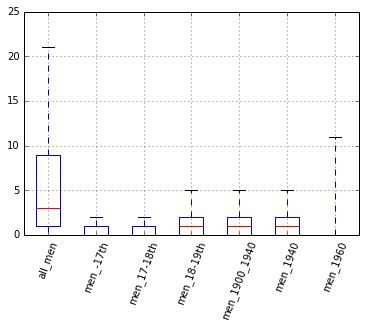

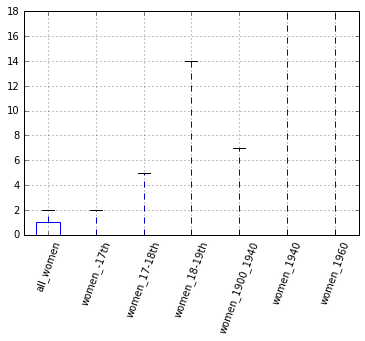

In [17]:
from collections import Counter
import pandas as pd
df_dat=pd.DataFrame.from_dict(dict_prof_names2,orient='index')
df_dat.fillna(value=0, inplace=True)

def group_by_century(x,y):
    new_d_1700=[]
    new_d_1700_1800=[]
    new_d_1800_1900=[]
    new_d_1900_1940=[]
    new_d_1940=[]
    new_d_1960=[]
    if isinstance(x, list):
        for d in x:
            if d>datetime.strptime("1940-1-1", '%Y-%m-%d').date():
                new_d_1940.append(d)
                if d>datetime.strptime("1960-1-1", '%Y-%m-%d').date():
                    new_d_1960.append(d)
            elif d>datetime.strptime("1900-1-1", '%Y-%m-%d').date():
                new_d_1900_1940.append(d)
            elif d>datetime.strptime("1800-1-1", '%Y-%m-%d').date():
                new_d_1800_1900.append(d)
            elif d>datetime.strptime("1700-1-1", '%Y-%m-%d').date():
                new_d_1700_1800.append(d)
            else:
                new_d_1700.append(d)    
        return pd.Series({'all_'+y: len(x), y+'_1940': len(new_d_1940), y+'_1960': len(new_d_1960),
                         y+'_1900_1940': len(new_d_1900_1940),y+'_18-19th': len(new_d_1800_1900),
                         y+'_17-18th': len(new_d_1700_1800),y+'_-17th': len(new_d_1700)})
    else:
        return pd.Series({'all_'+y: 0, y+'_1940': 0, y+'_1960': 0,y+'_1900_1940': 0})
dff=df_dat.men.apply(lambda x: group_by_century(x,"men"))
dff.boxplot(return_type='axes',showfliers=False)
plt.xticks(rotation=70)
plt.show()
dff_w=df_dat.women.apply(lambda x: group_by_century(x,"women"))
dff_w.boxplot(return_type='axes',showfliers=False)
plt.xticks(rotation=70)
plt.ylim(0,18)
plt.show()

In [18]:
df_m_w=pd.concat([dff,dff_w], axis=1)
df_m_w.fillna(value=0, inplace=True)

(array([1, 2, 3, 4, 5, 6, 7]), <a list of 7 Text xticklabel objects>)

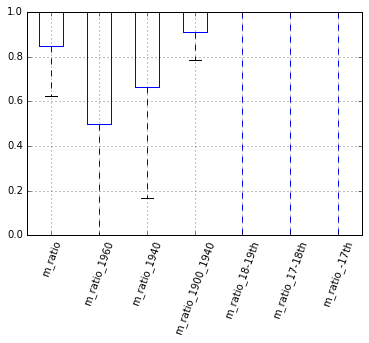

In [19]:
df_m_w["m_ratio"]=df_m_w.apply(lambda x: float(x["all_men"])/float(x["all_men"] + x["all_women"]), axis = 1)
df_m_w["m_ratio_1960"]=df_m_w.apply(lambda x: float(x.men_1960)/float(x.men_1960+x.women_1960) \
                                    if float(x.men_1960+x.women_1960)>0 else None, axis = 1)
df_m_w["m_ratio_1940"]=df_m_w.apply(lambda x: float(x.men_1940)/float(x.men_1940+x.women_1940) \
                                    if float(x.men_1940+x.women_1940)>0 else None, axis = 1)
df_m_w["m_ratio_1900_1940"]=df_m_w.apply(lambda x: float(x.men_1900_1940)/float(x.men_1900_1940+x.women_1900_1940) \
                                         if float(x.men_1900_1940+x.women_1900_1940)>0 else None, axis = 1)
df_m_w["m_ratio_18-19th"]=df_m_w.apply(lambda x: float(x["men_18-19th"])/float(x["men_18-19th"]+x["women_18-19th"]) \
                                         if float(x["men_18-19th"]+x["women_18-19th"])>0 else None, axis = 1)
df_m_w["m_ratio_17-18th"]=df_m_w.apply(lambda x: float(x["men_17-18th"])/float(x["men_17-18th"]+x["women_17-18th"]) \
                                         if float(x["men_17-18th"]+x["women_17-18th"])>0 else None, axis = 1)
df_m_w["m_ratio_-17th"]=df_m_w.apply(lambda x: float(x["men_-17th"])/float(x["men_-17th"]+x["women_-17th"]) \
                                         if float(x["men_-17th"]+x["women_-17th"])>0 else None, axis = 1)
g=df_m_w.boxplot(column=["m_ratio","m_ratio_1960","m_ratio_1940","m_ratio_1900_1940","m_ratio_18-19th",
                         "m_ratio_17-18th","m_ratio_-17th"],
                 return_type="axes",showfliers=False)
plt.xticks(rotation=70)

In [8]:
df_m_w["m_ratio_before1960"]=df_m_w.apply(lambda x: (float(x.all_men)-float(x.men_1960))/\
                                          float(x.all_men-x.men_1960+x.all_women-x.women_1960) \
                                    if float(x.all_men-x.men_1960+x.all_women-x.women_1960)>0 else None,
                                          axis = 1)


a=[]
for i in df_m_w.index.values:
    a.append( i.encode("utf8"))#.decode('iso-8859-1').
df_m_w.index=a
df_m_w.to_csv("de/people_with_birthDate.csv",encoding="utf8")